<a href="https://colab.research.google.com/github/Lalith2005reddy/HDR_Image_Segmentation/blob/main/Deeplab_phase5_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import numpy as np
import os
import random

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset Class
class ExposureDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))

        # Error Handling for Loading Images
        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path)
        except Exception as e:
            print(f"Error loading image or mask: {e}")
            return None

        # Apply the same transformations to both image and mask
        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

# Custom Transformations to Apply to Both Image and Mask
class PairedTransforms:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        # Random horizontal flip
        if random.random() < self.p:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        # Random vertical flip
        if random.random() < self.p:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)

        # Convert to tensor
        image = transforms.ToTensor()(image)
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask

# Define Transformations with Augmentation
paired_transform = PairedTransforms(p=0.5)

# Training and Validation Dataset
train_dataset = ExposureDataset('/content/drive/MyDrive/Dataset_phase5/train/train_img',
                                '/content/drive/MyDrive/Dataset_phase5/train/train_mask',
                                transform=paired_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

# Load pre-trained DeepLabv3 model with ResNet-101 backbone
model = models.segmentation.deeplabv3_resnet101(pretrained=True)

# Modify the classifier to match the number of classes (3 in your case: overexposed, underexposed, correctly exposed)
model.classifier[4] = nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Using AdamW optimizer

# Learning Rate Scheduler (Reduces LR on Plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training Loop
num_epochs = 25
best_loss = float('inf')  # Track the best loss

# Total number of images in the dataset
total_images = len(train_dataset)
print(f"Total number of images: {total_images}")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        # Handle potential None values
        if batch is None:
            continue

        images, masks = batch
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']

        # Calculate loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)

    # Learning rate scheduling
    scheduler.step(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save the best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_exposure_segmentation_model.pth')
        print("Model saved with lower loss.")

print("Training Complete")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LA

Total number of images: 419


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Loss: 0.7567
Model saved with lower loss.
Epoch [2/25], Loss: 0.5569
Model saved with lower loss.
Epoch [3/25], Loss: 0.4807
Model saved with lower loss.
Epoch [4/25], Loss: 0.4371
Model saved with lower loss.
Epoch [5/25], Loss: 0.4243
Model saved with lower loss.
Epoch [6/25], Loss: 0.3861
Model saved with lower loss.
Epoch [7/25], Loss: 0.4093
Epoch [8/25], Loss: 0.3610
Model saved with lower loss.
Epoch [9/25], Loss: 0.3401
Model saved with lower loss.
Epoch [10/25], Loss: 0.3150
Model saved with lower loss.
Epoch [11/25], Loss: 0.3099
Model saved with lower loss.
Epoch [12/25], Loss: 0.3028
Model saved with lower loss.
Epoch [13/25], Loss: 0.2914
Model saved with lower loss.
Epoch [14/25], Loss: 0.2923
Epoch [15/25], Loss: 0.2649
Model saved with lower loss.
Epoch [16/25], Loss: 0.2500
Model saved with lower loss.
Epoch [17/25], Loss: 0.2526
Epoch [18/25], Loss: 0.2681
Epoch [19/25], Loss: 0.2350
Model saved with lower loss.
Epoch [20/25], Loss: 0.2407
Epoch [21/25],

<ipython-input-2-b8c0ce103223>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth'

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-45-_exposure1-5_gamma1-5_jpg.rf.edf4bbb5a433c4dee1ae7f7f8db126e8.png


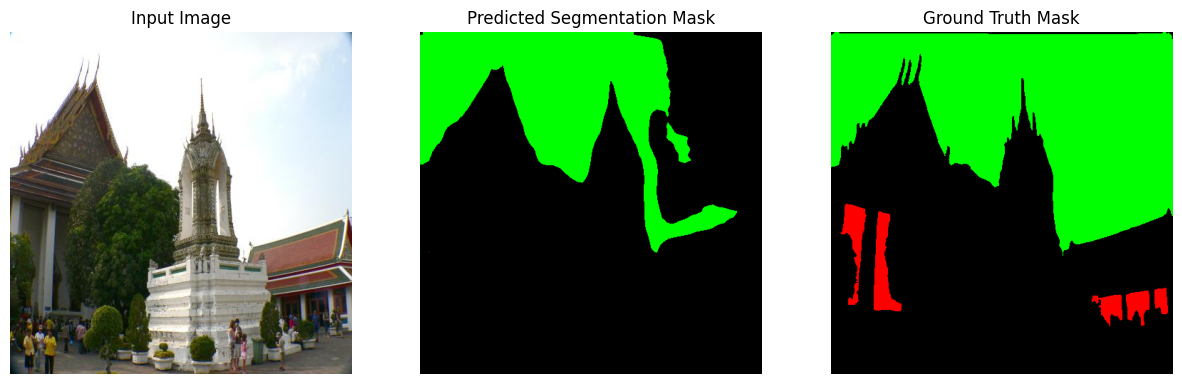

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-45-_exposure1-0_gamma1-0_jpg.rf.62699de57ab59be4d5ec7ff0b68481b5.png


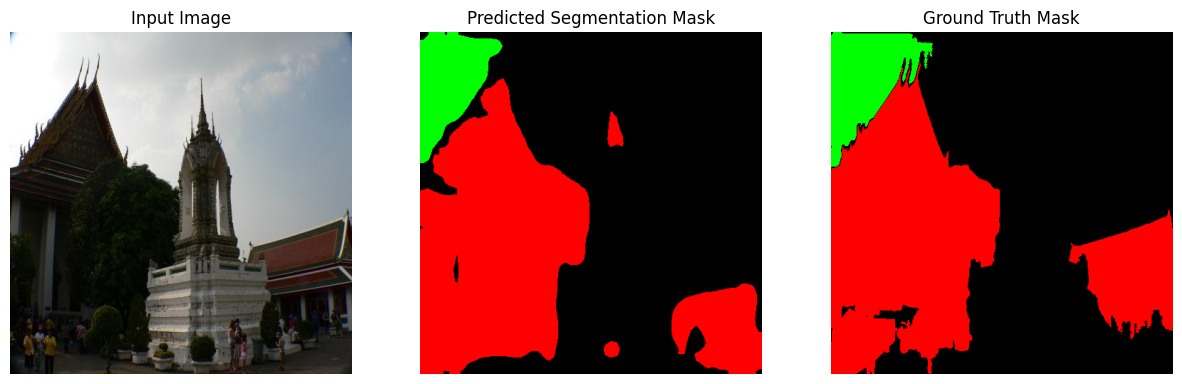

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-49-_exposure1-5_gamma1-5_jpg.rf.5f005f049591ad6517734a187cd2e5f9.png


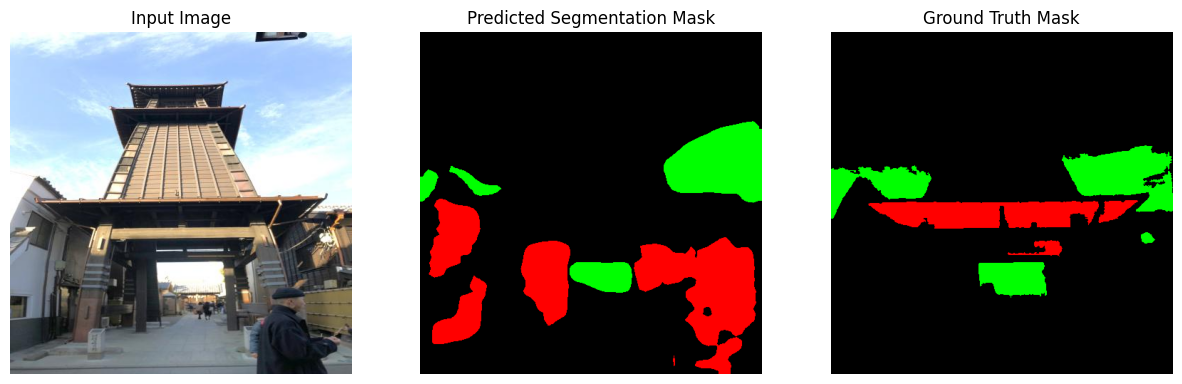

In [2]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Load the trained model
model = deeplabv3_resnet101(pretrained=False)
model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

# Load the state_dict while ignoring unnecessary keys
state_dict = torch.load('/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth', map_location=torch.device('cpu'))

# Filter out the `aux_classifier` keys
filtered_state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}

# Load the filtered state_dict
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict_image(image_path, model, device):
    """
    Predicts the segmentation mask for a given input image using the trained model.
    """
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (480, 480))
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Predict with the model
    with torch.no_grad():
        try:
            output = model(input_tensor)['out']  # Model output
            output = F.softmax(output, dim=1)  # Apply softmax to get class probabilities
            prediction = torch.argmax(output, dim=1).squeeze(0)  # Get the predicted class for each pixel
        except RuntimeError as e:
            print(f"Error during inference: {e}")
            return image, None

    return image, prediction.cpu().numpy()

def load_ground_truth(image_path, mask_dir):
    """
    Loads and processes the ground truth mask based on the input image path.
    """
    # Construct the corresponding ground truth mask path
    mask_name = os.path.basename(image_path).replace('.jpg', '.png')  # Assuming mask has the same name with a .png extension
    mask_path = os.path.join(mask_dir, mask_name)

    # Debugging: Print the mask path to check if it's correct
    print(f"Loading ground truth from: {mask_path}")

    # Read the mask in grayscale
    mask = cv2.imread(mask_path, 0)

    if mask is None:
        raise FileNotFoundError(f"Mask file not found or could not be read: {mask_path}")

    mask = cv2.resize(mask, (480, 480), interpolation=cv2.INTER_NEAREST)

    return mask

def visualize_results(image, prediction, ground_truth):
    """
    Visualizes the input image, predicted mask, and ground truth mask.
    """
    if prediction is None:
        print("Prediction is None. Skipping visualization.")
        return

    # Define color map for visualization
    colormap = np.array([[0, 0, 0],    # 0: Background (black)
                         [0, 255, 0],  # 1: Overexposed (green)
                         [255, 0, 0]]) # 2: Underexposed (red)

    # Create RGB masks
    rgb_prediction = colormap[prediction]
    rgb_ground_truth = colormap[ground_truth]

    # Plot the input image, predicted mask, and ground truth
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_prediction)
    plt.title("Predicted Segmentation Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(rgb_ground_truth)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.show()

def process_random_images(image_folder, mask_folder, num_images=3):
    """
    Selects a random set of images, predicts their masks, and visualizes the results.
    """
    # Get a list of image paths
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')]

    if len(image_paths) < num_images:
        raise ValueError("Not enough images in the folder to select the desired number of random images.")

    # Select random images
    selected_images = random.sample(image_paths, num_images)

    for img_path in selected_images:
        # Predict and visualize
        image, prediction = predict_image(img_path, model, device)
        ground_truth = load_ground_truth(img_path, mask_folder)
        visualize_results(image, prediction, ground_truth)

# Define folders
image_folder = '/content/drive/MyDrive/Dataset_phase5/test/test_img'  # Update to your image directory
mask_folder = '/content/drive/MyDrive/Dataset_phase5/test/test_mask'  # Update to your mask directory

# Process 3 random images
process_random_images(image_folder, mask_folder)

<ipython-input-3-4bbcdf14addf>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth'

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-50-_exposure1-5_gamma1-5_jpg.rf.b3b78d9ebad88b02b07337fbe257d51a.png
Time taken for prediction on img_-50-_exposure1-5_gamma1-5_jpg.rf.b3b78d9ebad88b02b07337fbe257d51a.jpg: 0.0268 seconds


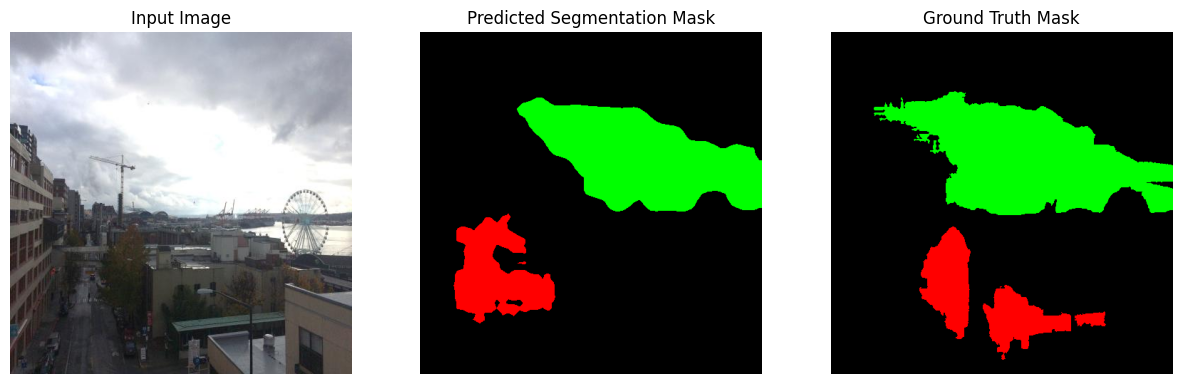

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-43-_exposure1-5_gamma1-5_jpg.rf.ab8222005cbb57ccaf8147040568f56a.png
Time taken for prediction on img_-43-_exposure1-5_gamma1-5_jpg.rf.ab8222005cbb57ccaf8147040568f56a.jpg: 0.0142 seconds


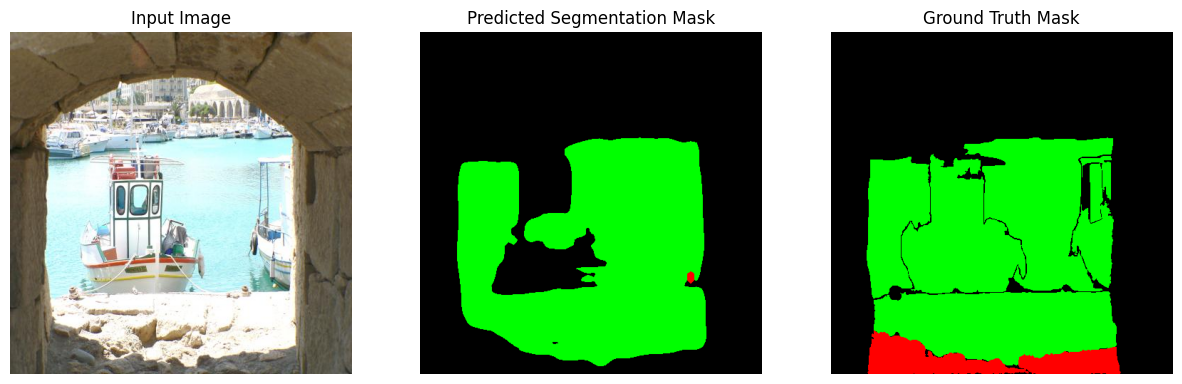

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-46-_exposure1-0_gamma1-0_jpg.rf.ced2a6c9c7371596e15d5405cc0cff98.png
Time taken for prediction on img_-46-_exposure1-0_gamma1-0_jpg.rf.ced2a6c9c7371596e15d5405cc0cff98.jpg: 0.0141 seconds


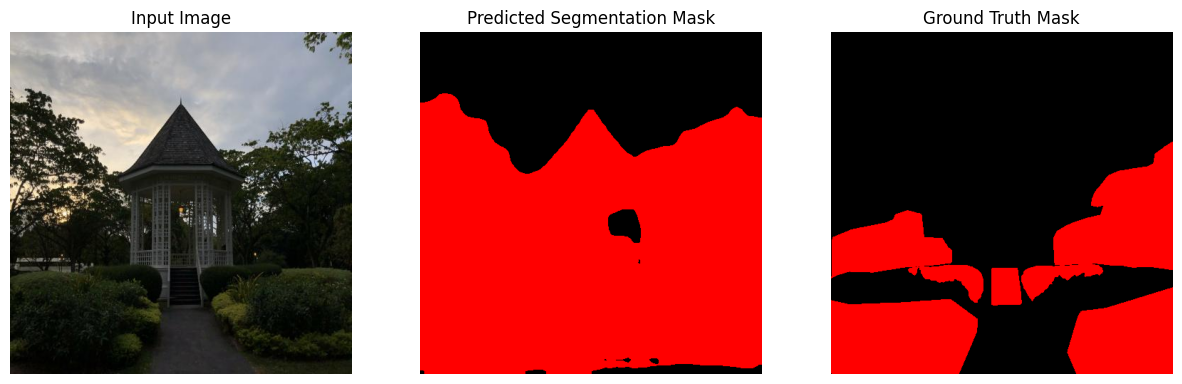

In [3]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import time

# Load the trained model
model = deeplabv3_resnet101(pretrained=False)
model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

# Load the state_dict while ignoring unnecessary keys
state_dict = torch.load('/content/drive/MyDrive/best_exposure_segmentation_model_phase5.pth', map_location=torch.device('cpu'))

# Filter out the `aux_classifier` keys
filtered_state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}

# Load the filtered state_dict
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict_image(image_path, model, device):
    """
    Predicts the segmentation mask for a given input image using the trained model
    and returns the time taken for prediction.
    """
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (480, 480))
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Start the timer
    start_time = time.time()

    # Predict with the model
    with torch.no_grad():
        try:
            output = model(input_tensor)['out']  # Model output
            output = F.softmax(output, dim=1)  # Apply softmax to get class probabilities
            prediction = torch.argmax(output, dim=1).squeeze(0)  # Get the predicted class for each pixel
        except RuntimeError as e:
            print(f"Error during inference: {e}")
            return image, None, None

    # Stop the timer and calculate the elapsed time
    elapsed_time = time.time() - start_time

    return image, prediction.cpu().numpy(), elapsed_time

def load_ground_truth(image_path, mask_dir):
    """
    Loads and processes the ground truth mask based on the input image path.
    """
    # Construct the corresponding ground truth mask path
    mask_name = os.path.basename(image_path).replace('.jpg', '.png')  # Assuming mask has the same name with a .png extension
    mask_path = os.path.join(mask_dir, mask_name)

    # Debugging: Print the mask path to check if it's correct
    print(f"Loading ground truth from: {mask_path}")

    # Read the mask in grayscale
    mask = cv2.imread(mask_path, 0)

    if mask is None:
        raise FileNotFoundError(f"Mask file not found or could not be read: {mask_path}")

    mask = cv2.resize(mask, (480, 480), interpolation=cv2.INTER_NEAREST)

    return mask

def visualize_results(image, prediction, ground_truth):
    """
    Visualizes the input image, predicted mask, and ground truth mask.
    """
    if prediction is None:
        print("Prediction is None. Skipping visualization.")
        return

    # Define color map for visualization
    colormap = np.array([[0, 0, 0],    # 0: Background (black)
                         [0, 255, 0],  # 1: Overexposed (green)
                         [255, 0, 0]]) # 2: Underexposed (red)

    # Create RGB masks
    rgb_prediction = colormap[prediction]
    rgb_ground_truth = colormap[ground_truth]

    # Plot the input image, predicted mask, and ground truth
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_prediction)
    plt.title("Predicted Segmentation Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(rgb_ground_truth)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.show()

def process_random_images(image_folder, mask_folder, num_images=3):
    """
    Selects a random set of images, predicts their masks, visualizes the results,
    and displays the time taken for prediction.
    """
    # Get a list of image paths
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')]

    if len(image_paths) < num_images:
        raise ValueError("Not enough images in the folder to select the desired number of random images.")

    # Select random images
    selected_images = random.sample(image_paths, num_images)

    for img_path in selected_images:
        # Predict and visualize
        image, prediction, elapsed_time = predict_image(img_path, model, device)
        ground_truth = load_ground_truth(img_path, mask_folder)

        # Display the time taken for prediction
        print(f"Time taken for prediction on {os.path.basename(img_path)}: {elapsed_time:.4f} seconds")

        visualize_results(image, prediction, ground_truth)

# Define folders
image_folder = '/content/drive/MyDrive/Dataset_phase5/test/test_img'  # Update to your image directory
mask_folder = '/content/drive/MyDrive/Dataset_phase5/test/test_mask'  # Update to your mask directory

# Process 3 random images
process_random_images(image_folder, mask_folder)

# Evalution Metrices

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-6-_exposure1-0_gamma1-0_jpg.rf.9595ff5be9ffbd9fe753c1611db3e581.png


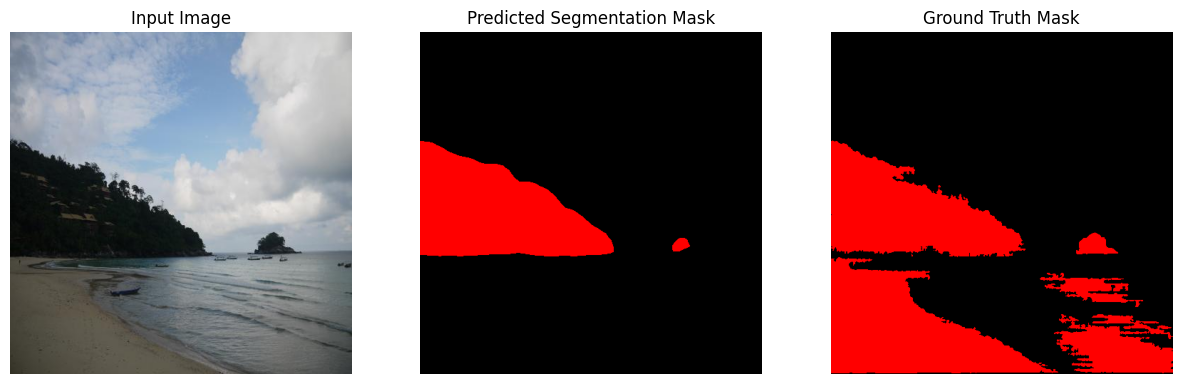

Image: img_-6-_exposure1-0_gamma1-0_jpg.rf.9595ff5be9ffbd9fe753c1611db3e581.jpg
Accuracy: 0.8156
IoU per class (Background, Overexposed, Underexposed): [0.7924739377241062, nan, 0.37691957934261283]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-44-_exposure1-5_gamma1-5_jpg.rf.7d27295c082ce985245f7d00ff1f3706.png


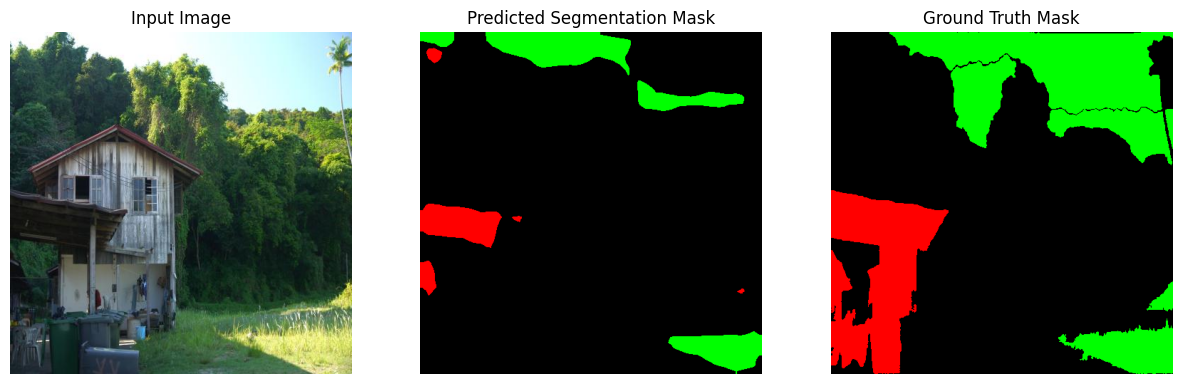

Image: img_-44-_exposure1-5_gamma1-5_jpg.rf.7d27295c082ce985245f7d00ff1f3706.jpg
Accuracy: 0.7795
IoU per class (Background, Overexposed, Underexposed): [0.7576327048464874, 0.3155891946140336, 0.23806312950398248]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-37-_exposure1-5_gamma1-5_jpg.rf.bd530d2707dc1895ff443b50b4bce90e.png


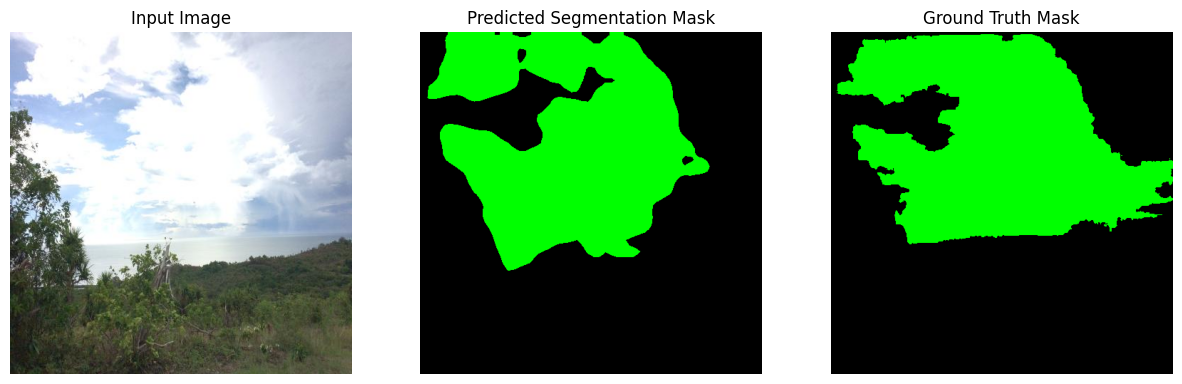

Image: img_-37-_exposure1-5_gamma1-5_jpg.rf.bd530d2707dc1895ff443b50b4bce90e.jpg
Accuracy: 0.9053
IoU per class (Background, Overexposed, Underexposed): [0.8624760488100041, 0.7667988414223571, nan]


Average Accuracy: 0.8335
Average IoU per class (Background, Overexposed, Underexposed): [0.80419423 0.54119402 0.30749135]


In [ ]:
def compute_metrics(prediction, ground_truth, num_classes=3):
    """
    Computes pixel-wise accuracy and IoU for each class.
    """
    # Initialize metrics
    correct_pixels = np.sum(prediction == ground_truth)
    total_pixels = ground_truth.size
    accuracy = correct_pixels / total_pixels

    iou_per_class = []
    for cls in range(num_classes):
        pred_cls = (prediction == cls)
        gt_cls = (ground_truth == cls)

        intersection = np.sum(pred_cls & gt_cls)
        union = np.sum(pred_cls | gt_cls)

        if union == 0:
            iou = np.nan  # Avoid division by zero
        else:
            iou = intersection / union
        iou_per_class.append(iou)

    return accuracy, iou_per_class

def process_random_images_with_metrics(image_folder, mask_folder, num_images=3):
    """
    Selects random images, predicts masks, visualizes results, and computes accuracy and IoU.
    """
    # Get a list of image paths
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')]

    if len(image_paths) < num_images:
        raise ValueError("Not enough images in the folder to select the desired number of random images.")

    # Initialize accumulators for metrics
    total_accuracy = 0
    total_iou = np.zeros(3)  # Assuming 3 classes: background, overexposed, underexposed
    valid_iou_counts = np.zeros(3)

    # Select random images
    selected_images = random.sample(image_paths, num_images)

    for img_path in selected_images:
        # Predict and visualize
        image, prediction = predict_image(img_path, model, device)
        ground_truth = load_ground_truth(img_path, mask_folder)

        # Compute metrics
        accuracy, iou_per_class = compute_metrics(prediction, ground_truth)

        # Accumulate metrics
        total_accuracy += accuracy
        for i, iou in enumerate(iou_per_class):
            if not np.isnan(iou):
                total_iou[i] += iou
                valid_iou_counts[i] += 1

        # Visualize the results
        visualize_results(image, prediction, ground_truth)

        # Print individual image metrics
        print(f"Image: {os.path.basename(img_path)}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"IoU per class (Background, Overexposed, Underexposed): {iou_per_class}\n")

    # Calculate and print average metrics
    avg_accuracy = total_accuracy / num_images
    avg_iou_per_class = total_iou / valid_iou_counts  # Avoid division by 0 for IoU

    print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
    print(f"Average IoU per class (Background, Overexposed, Underexposed): {avg_iou_per_class}")

# Process 3 random images with metrics
process_random_images_with_metrics(image_folder, mask_folder)

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-37-_exposure1-5_gamma1-5_jpg.rf.bd530d2707dc1895ff443b50b4bce90e.png


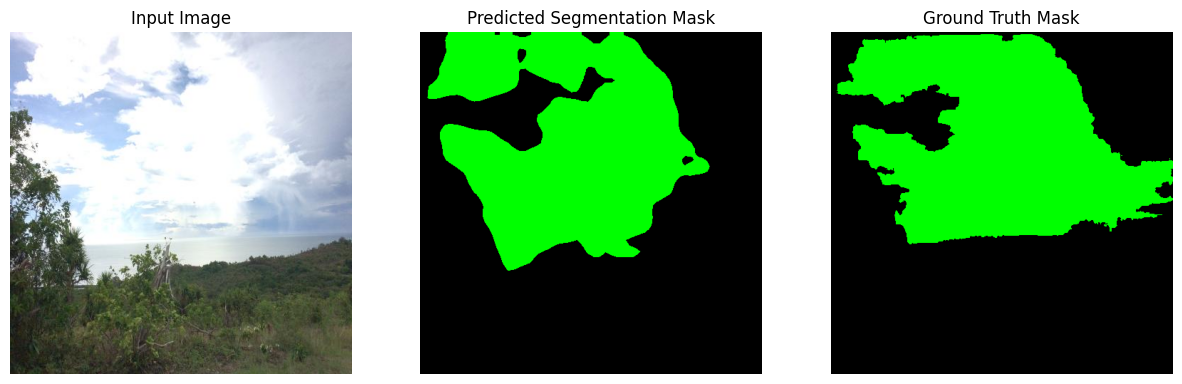

Image: img_-37-_exposure1-5_gamma1-5_jpg.rf.bd530d2707dc1895ff443b50b4bce90e.jpg
Accuracy: 0.9053
IoU per class (Background, Overexposed, Underexposed): [0.8624760488100041, 0.7667988414223571, nan]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-38-_exposure1-5_gamma1-5_jpg.rf.cfe66de75b5f6776cb85a2f4d931f7ee.png


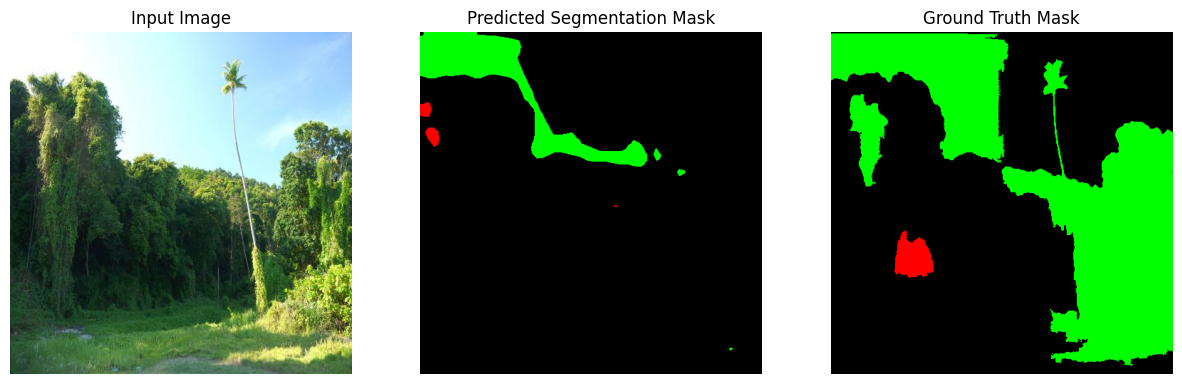

Image: img_-38-_exposure1-5_gamma1-5_jpg.rf.cfe66de75b5f6776cb85a2f4d931f7ee.jpg
Accuracy: 0.6953
IoU per class (Background, Overexposed, Underexposed): [0.6791555281376379, 0.14710184560983985, 0.0]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-42-_exposure1-5_gamma1-5_jpg.rf.79150e6441fce1be4c26860cce992cd0.png


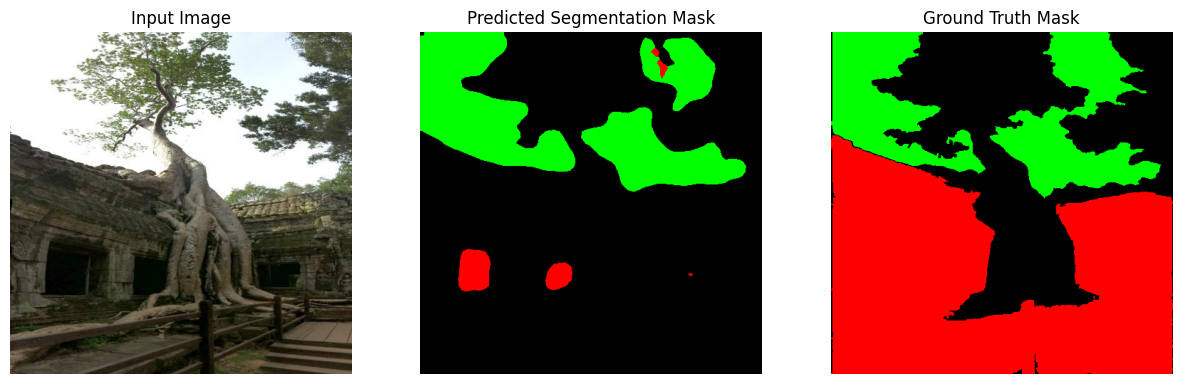

Image: img_-42-_exposure1-5_gamma1-5_jpg.rf.79150e6441fce1be4c26860cce992cd0.jpg
Accuracy: 0.5127
IoU per class (Background, Overexposed, Underexposed): [0.40491498405951115, 0.8141444931309667, 0.03217955651703624]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-45-_exposure1-0_gamma1-0_jpg.rf.62699de57ab59be4d5ec7ff0b68481b5.png


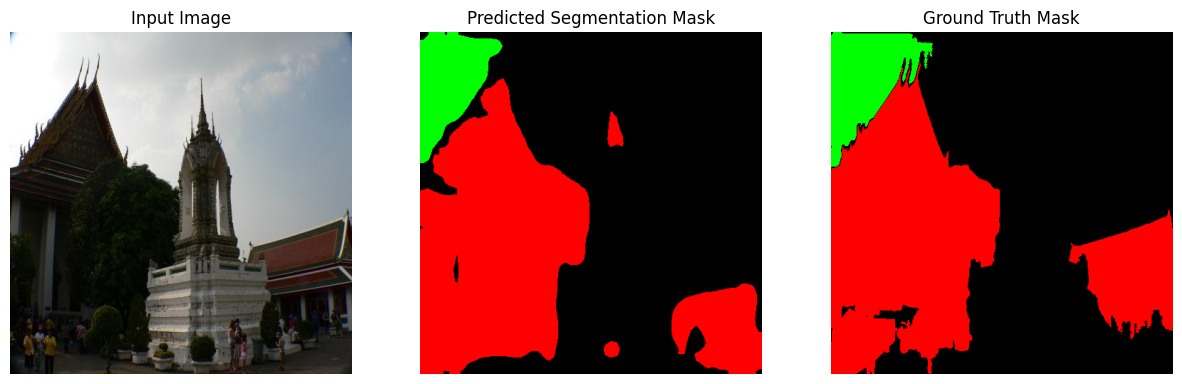

Image: img_-45-_exposure1-0_gamma1-0_jpg.rf.62699de57ab59be4d5ec7ff0b68481b5.jpg
Accuracy: 0.8795
IoU per class (Background, Overexposed, Underexposed): [0.8159702631840962, 0.8453659225769992, 0.7254372717243448]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-48-_exposure1-5_gamma1-5_jpg.rf.da024ee5cf42e0e277a6d6237781cdb6.png


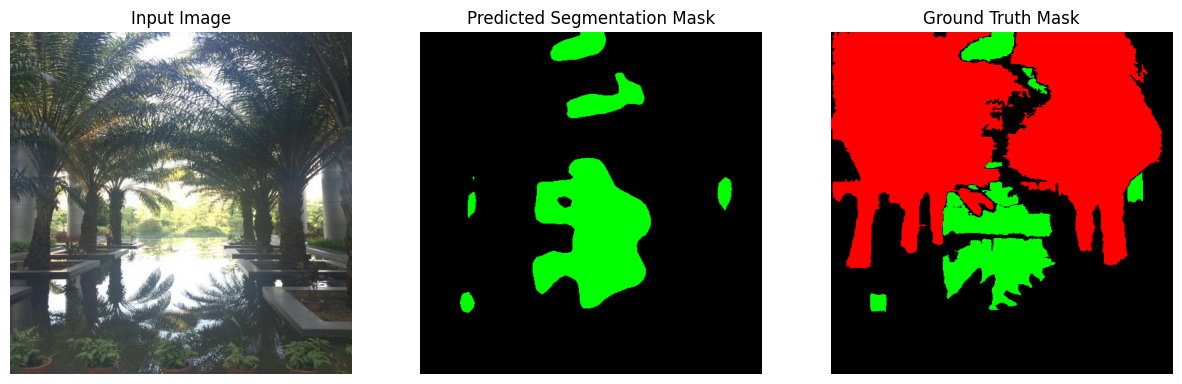

Image: img_-48-_exposure1-5_gamma1-5_jpg.rf.da024ee5cf42e0e277a6d6237781cdb6.jpg
Accuracy: 0.5219
IoU per class (Background, Overexposed, Underexposed): [0.49003572770824116, 0.5569059701974981, 0.0]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-50-_exposure1-5_gamma1-5_jpg.rf.b3b78d9ebad88b02b07337fbe257d51a.png


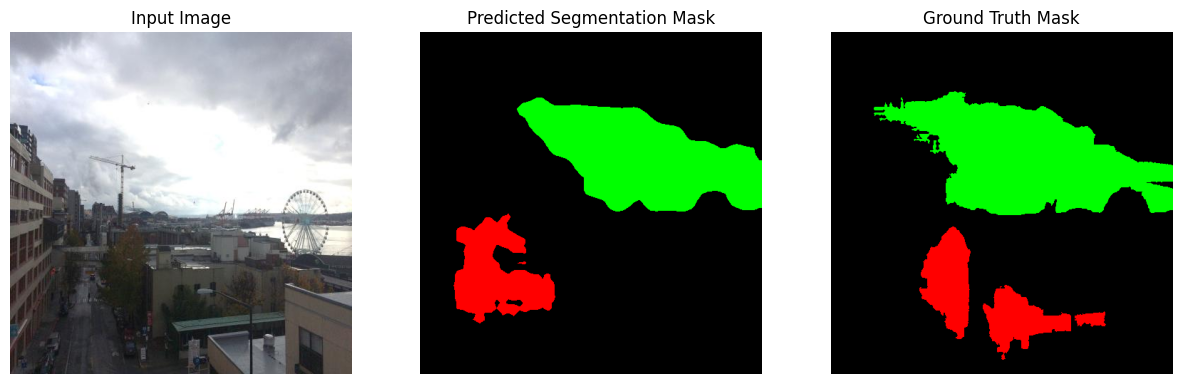

Image: img_-50-_exposure1-5_gamma1-5_jpg.rf.b3b78d9ebad88b02b07337fbe257d51a.jpg
Accuracy: 0.8596
IoU per class (Background, Overexposed, Underexposed): [0.8359945035721711, 0.7145048255031974, 0.12532941633905043]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-6-_exposure1-0_gamma1-0_jpg.rf.9595ff5be9ffbd9fe753c1611db3e581.png


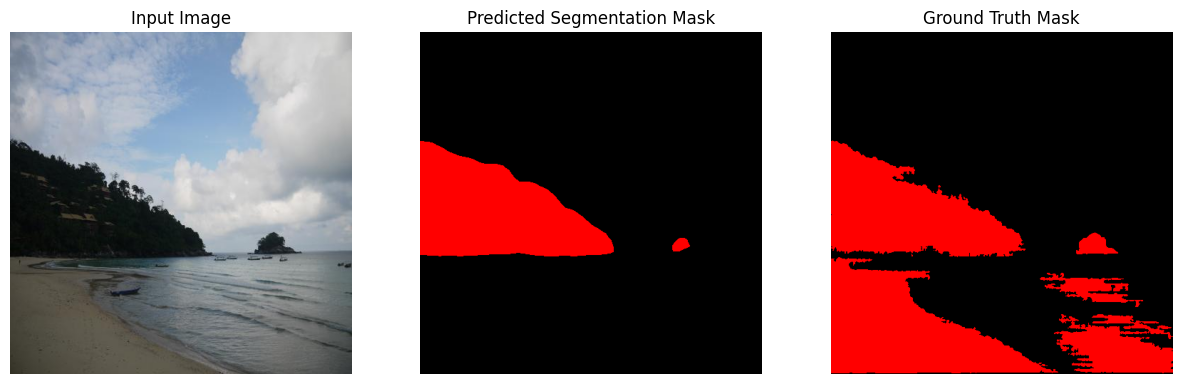

Image: img_-6-_exposure1-0_gamma1-0_jpg.rf.9595ff5be9ffbd9fe753c1611db3e581.jpg
Accuracy: 0.8156
IoU per class (Background, Overexposed, Underexposed): [0.7924739377241062, nan, 0.37691957934261283]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-9-_exposure1-0_gamma1-0_jpg.rf.2f94e5bf74b2d96c9a7a307dbd5ab038.png


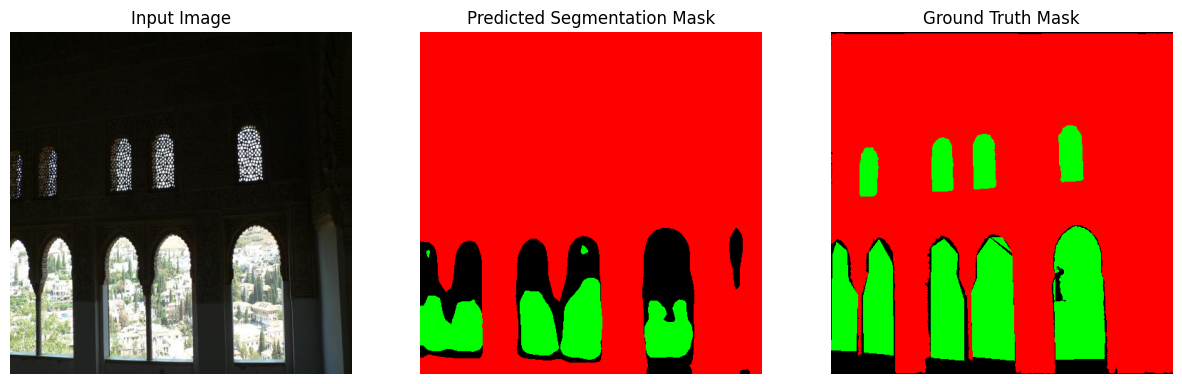

Image: img_-9-_exposure1-0_gamma1-0_jpg.rf.2f94e5bf74b2d96c9a7a307dbd5ab038.jpg
Accuracy: 0.8343
IoU per class (Background, Overexposed, Underexposed): [0.13471906074038575, 0.3948796526846709, 0.8988135404102929]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-4-_exposure1-0_gamma1-0_jpg.rf.4aacc46627ec3cf781a42513cf051b84.png


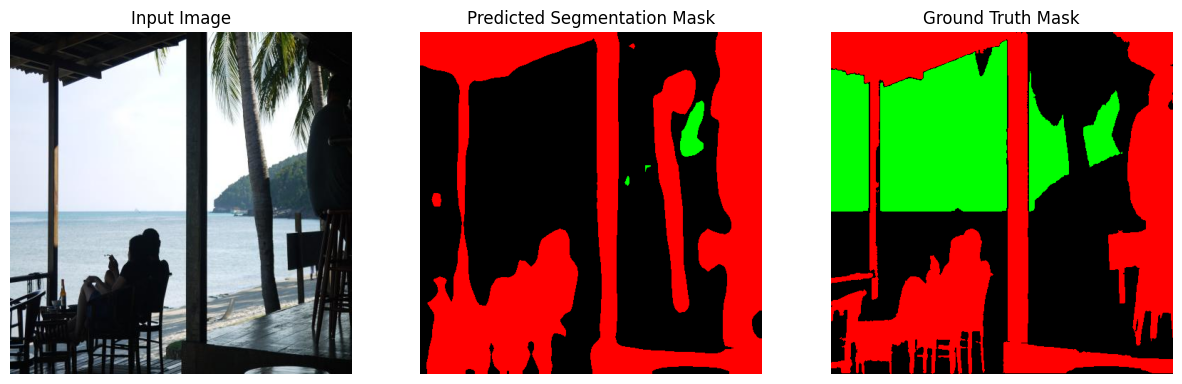

Image: img_-4-_exposure1-0_gamma1-0_jpg.rf.4aacc46627ec3cf781a42513cf051b84.jpg
Accuracy: 0.6512
IoU per class (Background, Overexposed, Underexposed): [0.4782239911264803, 0.03200698334182003, 0.7314096748705042]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-46-_exposure1-0_gamma1-0_jpg.rf.ced2a6c9c7371596e15d5405cc0cff98.png


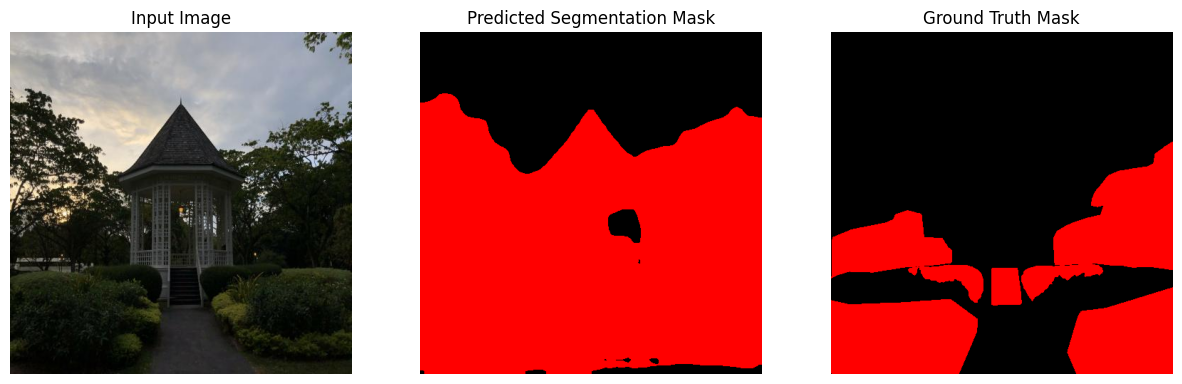

Image: img_-46-_exposure1-0_gamma1-0_jpg.rf.ced2a6c9c7371596e15d5405cc0cff98.jpg
Accuracy: 0.5992
IoU per class (Background, Overexposed, Underexposed): [0.4304630451943951, nan, 0.4249982877032185]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-44-_exposure1-0_gamma1-0_jpg.rf.c549de50047d60c5ac1c5537f3a51f03.png


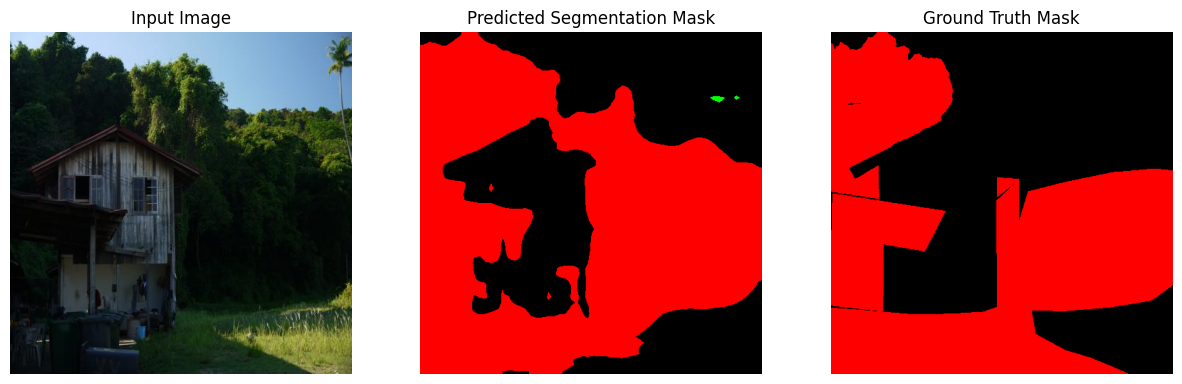

Image: img_-44-_exposure1-0_gamma1-0_jpg.rf.c549de50047d60c5ac1c5537f3a51f03.jpg
Accuracy: 0.8597
IoU per class (Background, Overexposed, Underexposed): [0.7365658014868919, 0.0, 0.7700192276076996]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-5-_exposure1-5_gamma1-5_jpg.rf.af04ad4a0e6a30c92ed624c82f63b2a5.png


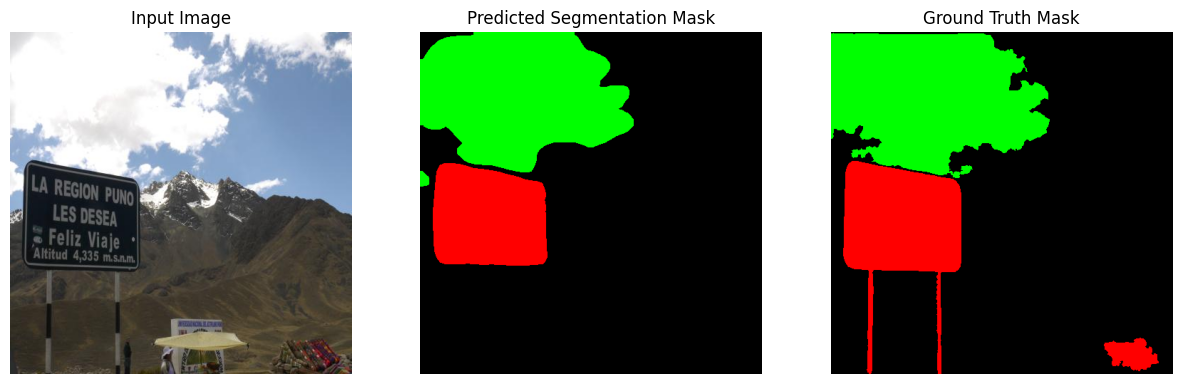

Image: img_-5-_exposure1-5_gamma1-5_jpg.rf.af04ad4a0e6a30c92ed624c82f63b2a5.jpg
Accuracy: 0.9513
IoU per class (Background, Overexposed, Underexposed): [0.9327054425192322, 0.9036554621848739, 0.7549771420144521]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-5-_exposure1-0_gamma1-0_jpg.rf.f3e56ec92696e98eb643a3938e9f237a.png


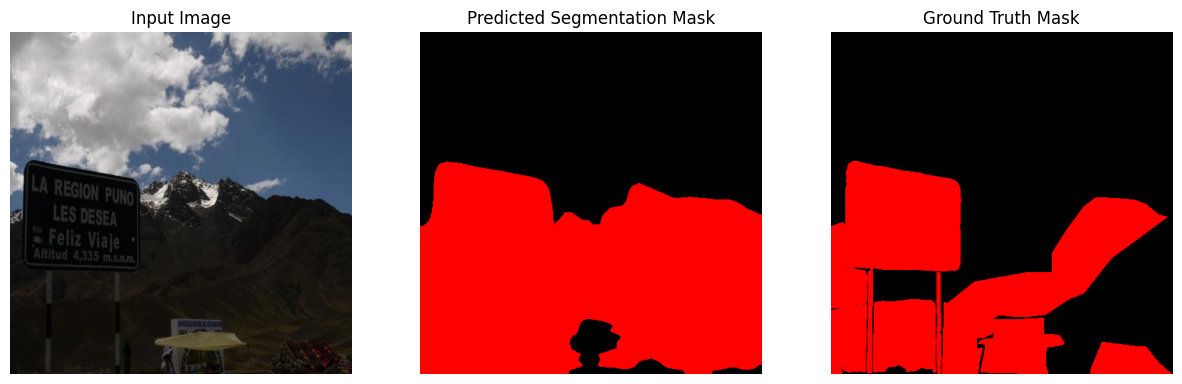

Image: img_-5-_exposure1-0_gamma1-0_jpg.rf.f3e56ec92696e98eb643a3938e9f237a.jpg
Accuracy: 0.7894
IoU per class (Background, Overexposed, Underexposed): [0.6928092163565008, nan, 0.5987598181066557]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-40-_exposure1-5_gamma1-5_jpg.rf.a66650fed2d7a3c7730be0bb1cd62833.png


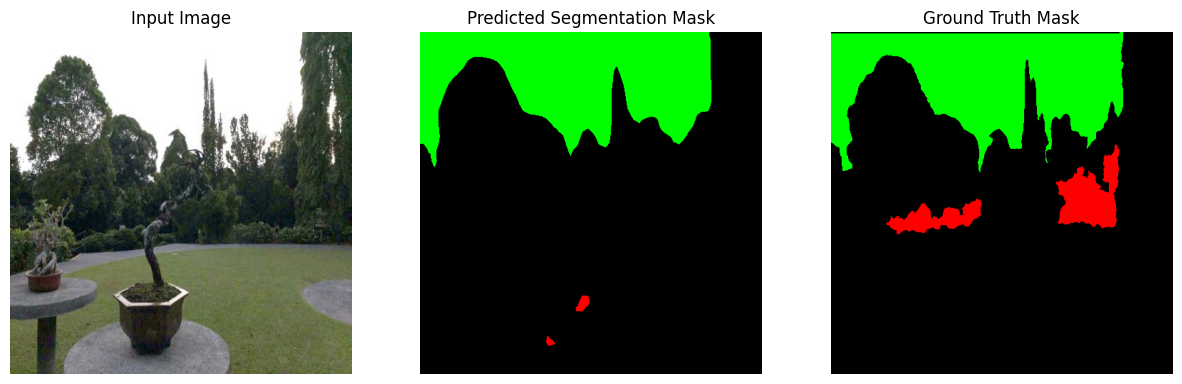

Image: img_-40-_exposure1-5_gamma1-5_jpg.rf.a66650fed2d7a3c7730be0bb1cd62833.jpg
Accuracy: 0.9465
IoU per class (Background, Overexposed, Underexposed): [0.9337993310677684, 0.9365689062433683, 0.0]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-43-_exposure1-0_gamma1-0_jpg.rf.161eb77edf1273acc9d62bf44b78cd29.png


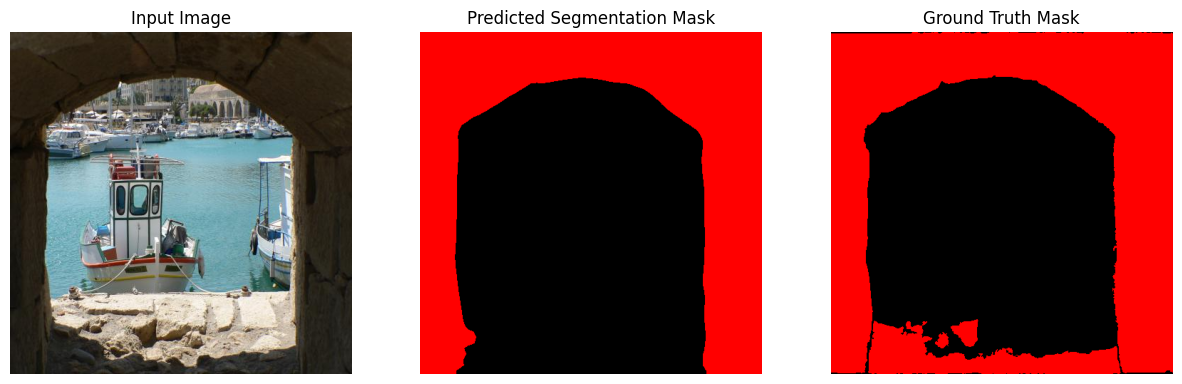

Image: img_-43-_exposure1-0_gamma1-0_jpg.rf.161eb77edf1273acc9d62bf44b78cd29.jpg
Accuracy: 0.9314
IoU per class (Background, Overexposed, Underexposed): [0.883760281329547, nan, 0.8567205324917931]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-44-_exposure1-5_gamma1-5_jpg.rf.7d27295c082ce985245f7d00ff1f3706.png


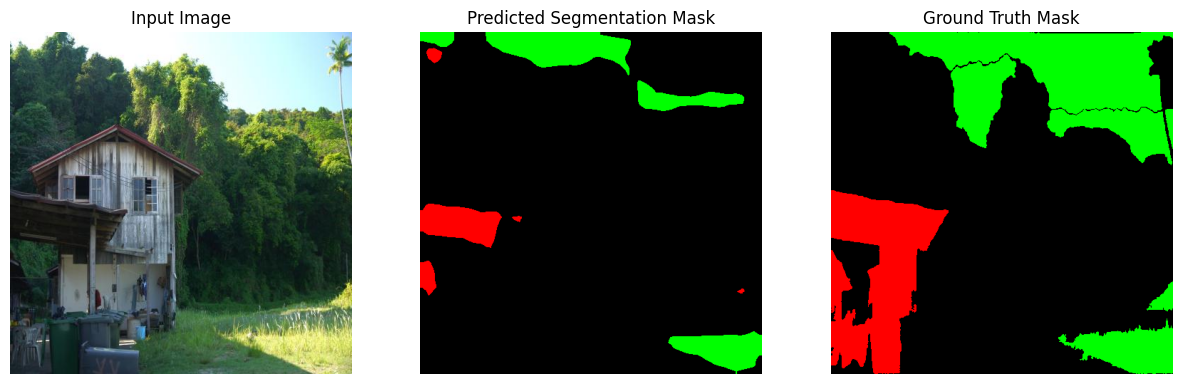

Image: img_-44-_exposure1-5_gamma1-5_jpg.rf.7d27295c082ce985245f7d00ff1f3706.jpg
Accuracy: 0.7795
IoU per class (Background, Overexposed, Underexposed): [0.7576327048464874, 0.3155891946140336, 0.23806312950398248]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-46-_exposure1-5_gamma1-5_jpg.rf.6ae10fde97b5df21b15d84c9a6b8a5fd.png


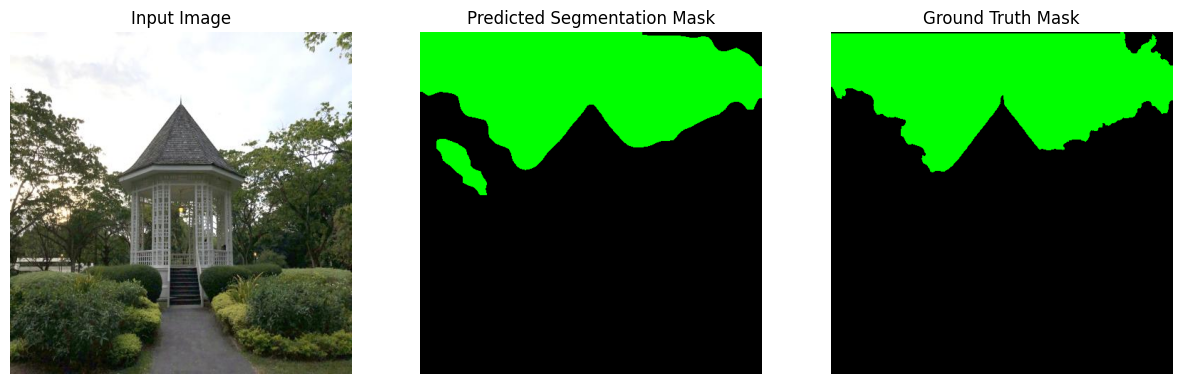

Image: img_-46-_exposure1-5_gamma1-5_jpg.rf.6ae10fde97b5df21b15d84c9a6b8a5fd.jpg
Accuracy: 0.9763
IoU per class (Background, Overexposed, Underexposed): [0.9679637892317524, 0.9163336242669239, nan]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-41-_exposure1-0_gamma1-0_jpg.rf.629d3fac43e547a72cc1cdeee1656403.png


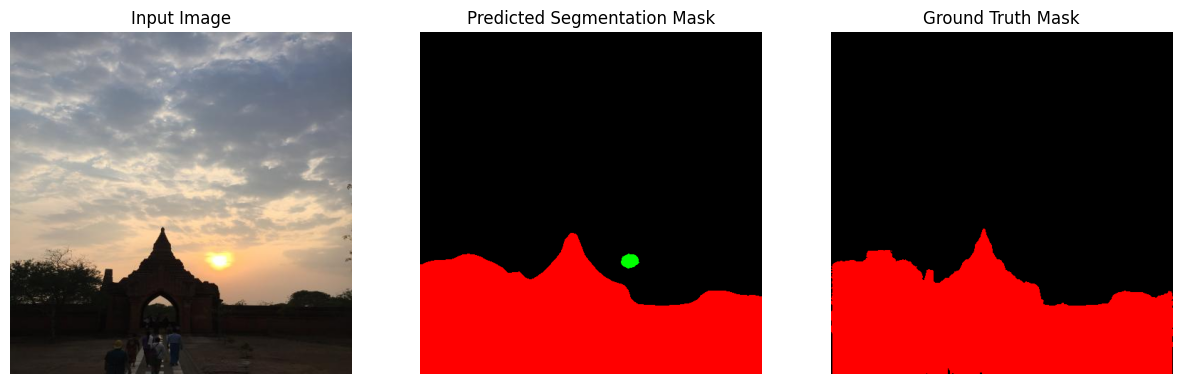

Image: img_-41-_exposure1-0_gamma1-0_jpg.rf.629d3fac43e547a72cc1cdeee1656403.jpg
Accuracy: 0.9919
IoU per class (Background, Overexposed, Underexposed): [0.9887950125168496, 0.0, 0.9776235272627637]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-7-_exposure1-5_gamma1-5_jpg.rf.c8e1f4b9bf7121c64ce97e6ac9fe2fa6.png


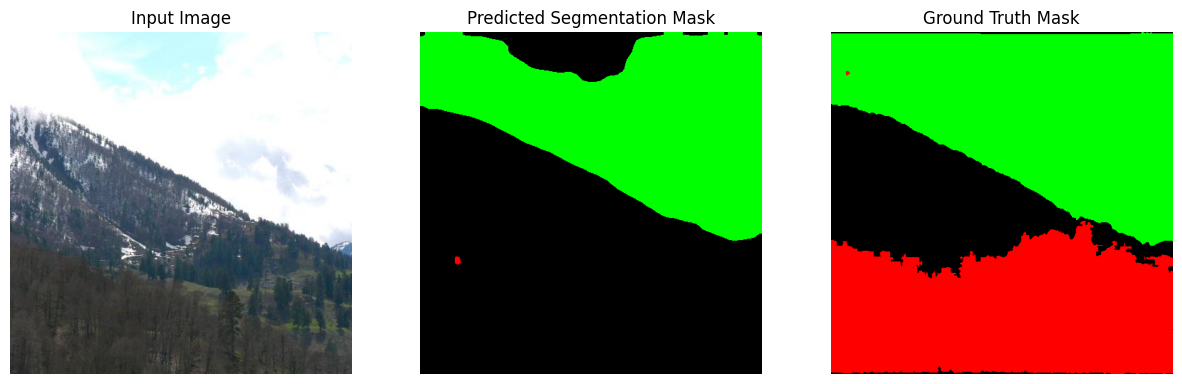

Image: img_-7-_exposure1-5_gamma1-5_jpg.rf.c8e1f4b9bf7121c64ce97e6ac9fe2fa6.jpg
Accuracy: 0.5977
IoU per class (Background, Overexposed, Underexposed): [0.3634540221594851, 0.8843535994655086, 0.0009666919556545361]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-41-_exposure1-5_gamma1-5_jpg.rf.8f2bb8bc1df87b2ef17247162ccdafb6.png


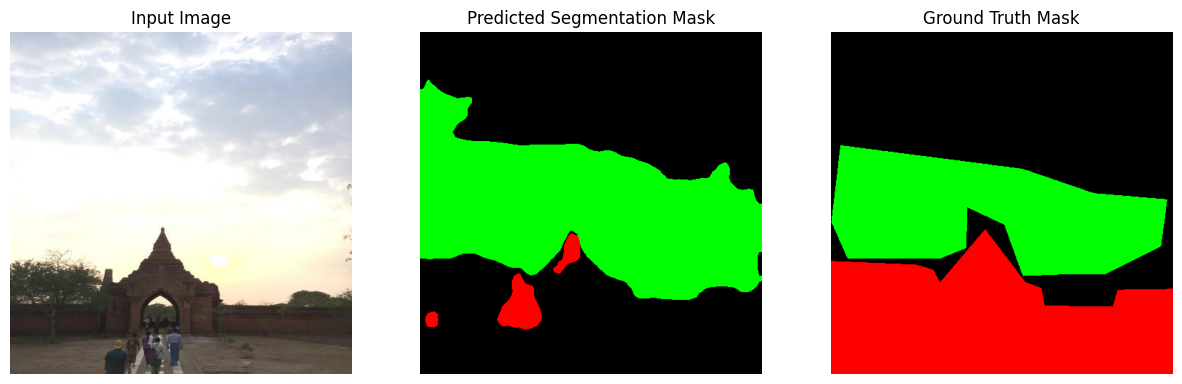

Image: img_-41-_exposure1-5_gamma1-5_jpg.rf.8f2bb8bc1df87b2ef17247162ccdafb6.jpg
Accuracy: 0.6169
IoU per class (Background, Overexposed, Underexposed): [0.4843634949900744, 0.6690958587294322, 0.06633776091081595]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-39-_exposure1-5_gamma1-5_jpg.rf.d7cf80ea1a11e85dc3332b3e834f210a.png


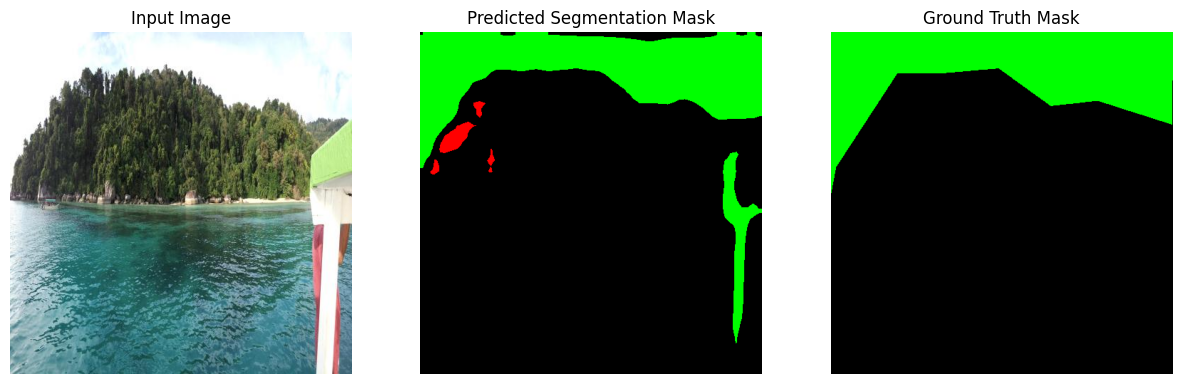

Image: img_-39-_exposure1-5_gamma1-5_jpg.rf.d7cf80ea1a11e85dc3332b3e834f210a.jpg
Accuracy: 0.9530
IoU per class (Background, Overexposed, Underexposed): [0.9430922504571536, 0.8124657950744907, 0.0]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-8-_exposure1-5_gamma1-5_jpg.rf.be0b84a679792a9ca4dc722250537381.png


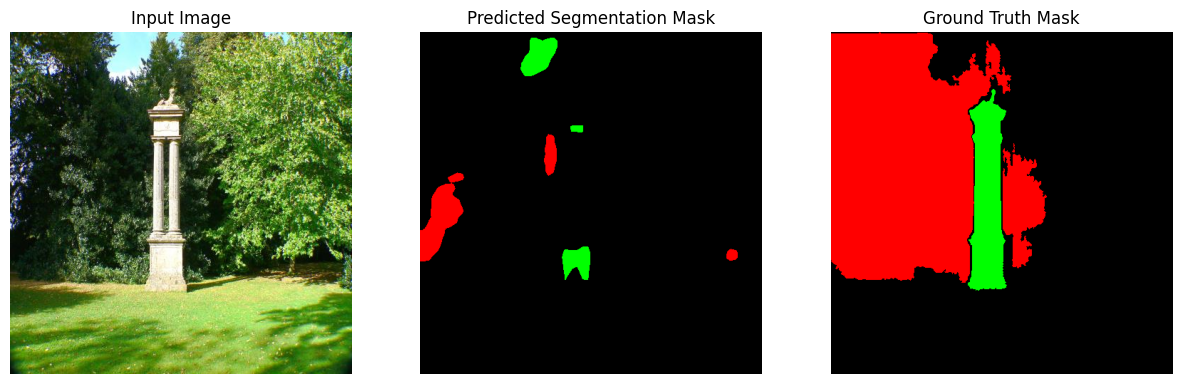

Image: img_-8-_exposure1-5_gamma1-5_jpg.rf.be0b84a679792a9ca4dc722250537381.jpg
Accuracy: 0.6572
IoU per class (Background, Overexposed, Underexposed): [0.6479976112165861, 0.12118549289023806, 0.06209731937143882]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-45-_exposure1-5_gamma1-5_jpg.rf.edf4bbb5a433c4dee1ae7f7f8db126e8.png


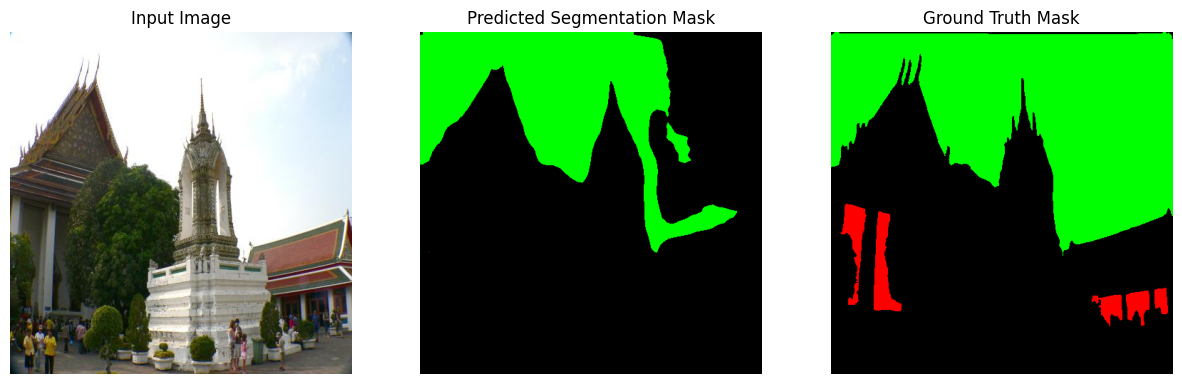

Image: img_-45-_exposure1-5_gamma1-5_jpg.rf.edf4bbb5a433c4dee1ae7f7f8db126e8.jpg
Accuracy: 0.7971
IoU per class (Background, Overexposed, Underexposed): [0.7377577066561948, 0.5694550617014306, 0.0]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-43-_exposure1-5_gamma1-5_jpg.rf.ab8222005cbb57ccaf8147040568f56a.png


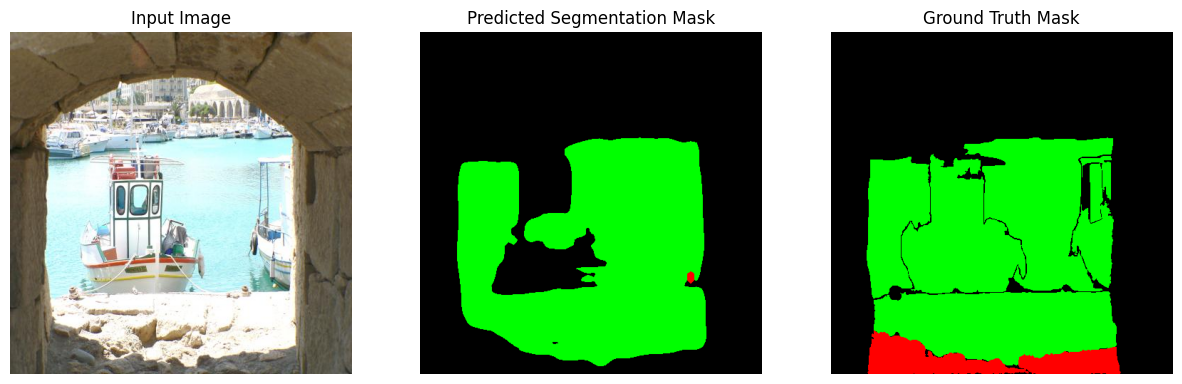

Image: img_-43-_exposure1-5_gamma1-5_jpg.rf.ab8222005cbb57ccaf8147040568f56a.jpg
Accuracy: 0.8590
IoU per class (Background, Overexposed, Underexposed): [0.7931628470221019, 0.7748187252223568, 0.0]

Loading ground truth from: /content/drive/MyDrive/Dataset_phase5/test/test_mask/img_-49-_exposure1-5_gamma1-5_jpg.rf.5f005f049591ad6517734a187cd2e5f9.png


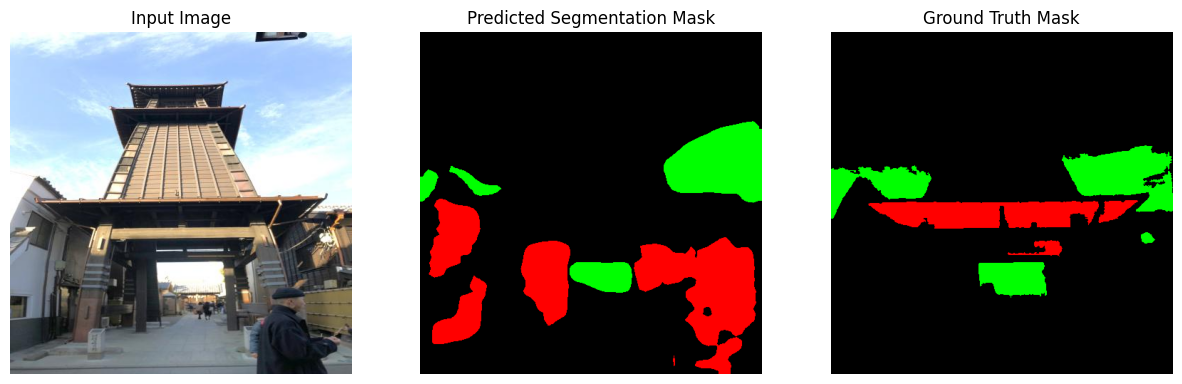

Image: img_-49-_exposure1-5_gamma1-5_jpg.rf.5f005f049591ad6517734a187cd2e5f9.jpg
Accuracy: 0.7770
IoU per class (Background, Overexposed, Underexposed): [0.7640857035275102, 0.564656562399226, 0.008700586343862303]


Average Accuracy: 0.7903
Average IoU per class (Background, Overexposed, Underexposed): [0.70209489 0.55904223 0.33258057]


In [ ]:
def process_all_images_with_metrics(image_folder, mask_folder):
    """
    Evaluates all images in the specified folders, predicts masks, computes accuracy, IoU, and visualizes results.
    """
    # Get a list of image paths
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')]

    if len(image_paths) == 0:
        raise ValueError("No images found in the folder.")

    # Initialize accumulators for metrics
    total_accuracy = 0
    total_iou = np.zeros(3)  # Assuming 3 classes: background, overexposed, underexposed
    valid_iou_counts = np.zeros(3)

    # Process all images in the folder
    for img_path in image_paths:
        # Predict the mask for the image
        image, prediction = predict_image(img_path, model, device)

        # Load the ground truth mask
        ground_truth = load_ground_truth(img_path, mask_folder)

        # Compute metrics
        accuracy, iou_per_class = compute_metrics(prediction, ground_truth)

        # Accumulate metrics
        total_accuracy += accuracy
        for i, iou in enumerate(iou_per_class):
            if not np.isnan(iou):
                total_iou[i] += iou
                valid_iou_counts[i] += 1

        # Visualize the results for each image
        visualize_results(image, prediction, ground_truth)

        # Print individual image metrics
        print(f"Image: {os.path.basename(img_path)}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"IoU per class (Background, Overexposed, Underexposed): {iou_per_class}\n")

    # Calculate and print average metrics
    avg_accuracy = total_accuracy / len(image_paths)
    avg_iou_per_class = total_iou / valid_iou_counts  # Avoid division by 0 for IoU

    print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
    print(f"Average IoU per class (Background, Overexposed, Underexposed): {avg_iou_per_class}")

# Specify the image and mask folders
image_folder = '/content/drive/MyDrive/Dataset_phase5/test/test_img'  # Update this with the path to your image folder
mask_folder = '/content/drive/MyDrive/Dataset_phase5/test/test_mask'    # Update this with the path to your mask folder

# Process all images in the specified folders
process_all_images_with_metrics(image_folder, mask_folder)